In [5]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sqlalchemy import create_engine
import os

# =========================
# Connexion PostgreSQL
# =========================
PGHOST = os.getenv("PGHOST", "localhost")
PGPORT = os.getenv("PGPORT", "5432")
PGDB   = os.getenv("PGDATABASE", "qualair_db")
PGUSER = os.getenv("PGUSER", "yasminedri")
PGPASS = os.getenv("PGPASSWORD", "qualair")

engine = create_engine(f"postgresql+psycopg2://{PGUSER}:{PGPASS}@{PGHOST}:{PGPORT}/{PGDB}")

In [10]:
df_pollution = pd.read_sql(f"""
    SELECT DATE_TRUNC('hour', mj.datetime) AS heure,
           s.ville,
           mj.polluant,
           AVG(mj.valeur) AS valeur_moyenne
    FROM mesure_journaliere mj
    JOIN station s ON mj.id_station = s.id_station
    WHERE s.ville = '{ville_select}'
      AND mj.polluant = '{polluant_select}'
      AND mj.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
      AND mj.valeur IS NOT NULL
    GROUP BY DATE_TRUNC('hour', mj.datetime), s.ville, mj.polluant
    ORDER BY heure
""", engine)


fig_pollution = px.line(
    df_pollution,
    x="heure",
    y="valeur_moyenne",
    title=f"{polluant_select} à {ville_select} – Moyenne horaire",
    markers=True
)

fig_pollution.update_traces(line=dict(width=2, color="#1f77b4"))
fig_pollution.update_layout(
    xaxis_title="Heure",
    yaxis_title=f"{polluant_select} (µg/m³)",
    plot_bgcolor="white",
    font=dict(size=14),
    title_font=dict(size=18),
    hovermode="x unified"
)

# Seuil réglementaire NO2 (exemple)
if polluant_select.upper() == "NO2":
    fig_pollution.add_hline(
        y=40,
        line_dash="dash",
        line_color="red",
        annotation_text="Seuil réglementaire (40 µg/m³)",
        annotation_position="top right"
    )

fig_pollution.show()


In [14]:
periode_debut = "2025-08-08"
periode_fin = "2025-08-15"
ville_select = "Nice"

df_multi = pd.read_sql(f"""
    SELECT DATE(mj.datetime) AS jour,
           mj.polluant,
           AVG(mj.valeur) AS valeur_moyenne
    FROM mesure_journaliere mj
    JOIN station s ON mj.id_station = s.id_station
    WHERE s.ville = '{ville_select}'
      AND mj.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'
      AND mj.valeur IS NOT NULL
    GROUP BY jour, mj.polluant
    ORDER BY jour
""", engine)

fig_multi = px.line(
    df_multi,
    x="jour",
    y="valeur_moyenne",
    color="polluant",
    title=f"Évolution journalière multi-polluants à {ville_select}",
    markers=True
)

fig_multi.update_layout(
    xaxis_title="Jour",
    yaxis_title="Concentration moyenne (µg/m³)",
    plot_bgcolor="white",
    hovermode="x unified"
)

# Seuils réglementaires en fonction du polluant
seuils = {"NO2": 40, "PM10": 50}
for pol, seuil in seuils.items():
    fig_multi.add_hline(
        y=seuil,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Seuil {pol} ({seuil} µg/m³)",
        annotation_position="top left"
    )

fig_multi.show()


In [15]:
ville_select = "Nice"
polluant_select = "NO2"
periode_debut = "2025-08-14"
periode_fin = "2025-08-14"

# Données météo
df_meteo = pd.read_sql(f"""
    SELECT time, temperature_2m, relative_humidity_2m, windspeed_10m, precipitation
    FROM meteo
    WHERE ville = '{ville_select}'
      AND time BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
""", engine)

# Données pollution (moyenne horaire)
df_pollution = pd.read_sql(f"""
    SELECT DATE_TRUNC('hour', mj.datetime) AS heure,
           AVG(mj.valeur) AS valeur_moyenne
    FROM mesure_journaliere mj
    JOIN station s ON mj.id_station = s.id_station
    WHERE s.ville = '{ville_select}'
      AND mj.polluant = '{polluant_select}'
      AND mj.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
      AND mj.valeur IS NOT NULL
    GROUP BY DATE_TRUNC('hour', mj.datetime)
    ORDER BY heure
""", engine)

import plotly.graph_objects as go

fig = go.Figure()

# Axe 1 : Pollution
fig.add_trace(go.Scatter(
    x=df_pollution["heure"],
    y=df_pollution["valeur_moyenne"],
    name=f"{polluant_select} (µg/m³)",
    mode="lines+markers",
    line=dict(color="red"),
    yaxis="y1"
))

# Axe 2 : Température
fig.add_trace(go.Scatter(
    x=df_meteo["time"],
    y=df_meteo["temperature_2m"],
    name="Température (°C)",
    mode="lines",
    line=dict(color="blue"),
    yaxis="y2"
))

# Mise en page
fig.update_layout(
    title=f"{polluant_select} vs Température – {ville_select}",
    xaxis=dict(title="Date et heure"),
    yaxis=dict(title=f"{polluant_select} (µg/m³)", side="left"),
    yaxis2=dict(title="Température (°C)", overlaying="y", side="right"),
    plot_bgcolor="white",
    hovermode="x unified"
)

fig.show()


Corrélation Pearson NO₂ / Température : 0.11


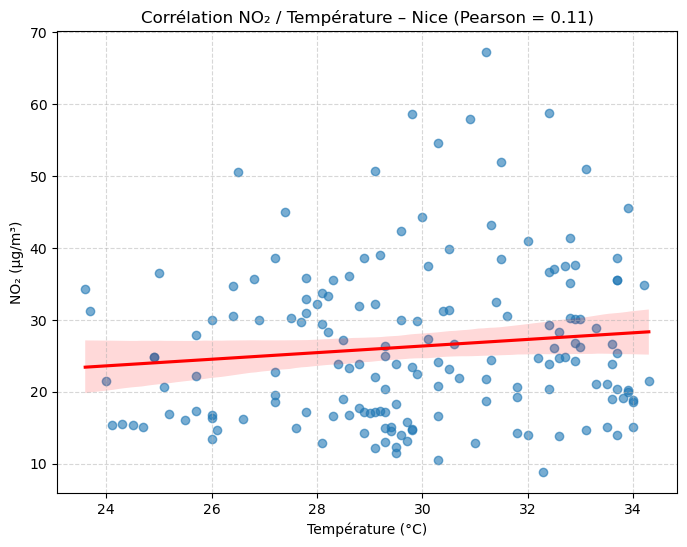

In [18]:
ville_cible = "Nice"
polluant_cible = "NO2"
periode_debut = "2025-08-08"
periode_fin = "2025-08-15"

# NO2 (moyenne horaire)
query_no2 = f"""
SELECT DATE_TRUNC('hour', m.datetime) AS heure,
       AVG(m.valeur) AS no2
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = '{ville_cible}'
  AND m.polluant = '{polluant_cible}'
  AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
  AND m.valeur IS NOT NULL
GROUP BY DATE_TRUNC('hour', m.datetime)
ORDER BY heure
"""
df_no2 = pd.read_sql(query_no2, engine)

# Température (moyenne horaire)
query_temp = f"""
SELECT DATE_TRUNC('hour', time) AS heure,
       AVG(temperature_2m) AS temperature
FROM meteo
WHERE ville = '{ville_cible}'
  AND time BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
GROUP BY DATE_TRUNC('hour', time)
ORDER BY heure
"""
df_temp = pd.read_sql(query_temp, engine)

# Fusion sur heure
df_no2_temp = pd.merge(df_no2, df_temp, on="heure", how="inner")

# Corrélation Pearson
corr_value = df_no2_temp['no2'].corr(df_no2_temp['temperature'])
print(f"Corrélation Pearson NO₂ / Température : {corr_value:.2f}")

# Scatter + régression
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.regplot(
    data=df_no2_temp,
    x="temperature",
    y="no2",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.title(f"Corrélation NO₂ / Température – {ville_cible} (Pearson = {corr_value:.2f})")
plt.xlabel("Température (°C)")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Corrélation Pearson NO₂ / Température : -0.07


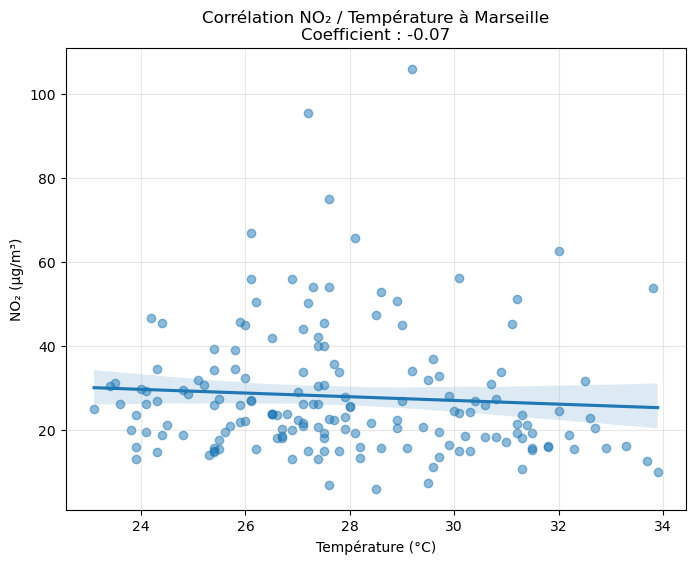

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Récupérer toutes les mesures de polluants pour Marseille ---
query_polluants = """
SELECT m.datetime, m.polluant, m.valeur
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = 'Marseille'
"""
df_polluants = pd.read_sql(query_polluants, engine)

# ⚠ Supprimer doublons éventuels
df_polluants = df_polluants.drop_duplicates(subset=["datetime", "polluant"])

# Pivot pour avoir un polluant = 1 colonne
df_polluants_pivot = df_polluants.pivot(index="datetime", columns="polluant", values="valeur").reset_index()

# --- 2. Récupérer les données météo ---
query_meteo = """
SELECT time AS datetime, temperature_2m, relative_humidity_2m, windspeed_10m
FROM meteo
WHERE ville = 'Marseille'
"""
df_meteo = pd.read_sql(query_meteo, engine)

# --- 3. Fusion polluants + météo ---
df_merged = pd.merge(df_polluants_pivot, df_meteo, on="datetime", how="inner")

# --- 4. Exemple : corrélation avec NO₂ ---
corr_value = df_merged["NO2"].corr(df_merged["temperature_2m"])
print(f"Corrélation Pearson NO₂ / Température : {corr_value:.2f}")

# --- 5. Visualisation exemple ---
plt.figure(figsize=(8,6))
sns.regplot(x="temperature_2m", y="NO2", data=df_merged, scatter_kws={'alpha':0.5})
plt.title(f"Corrélation NO₂ / Température à Marseille\nCoefficient : {corr_value:.2f}")
plt.xlabel("Température (°C)")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, alpha=0.3)
plt.show()


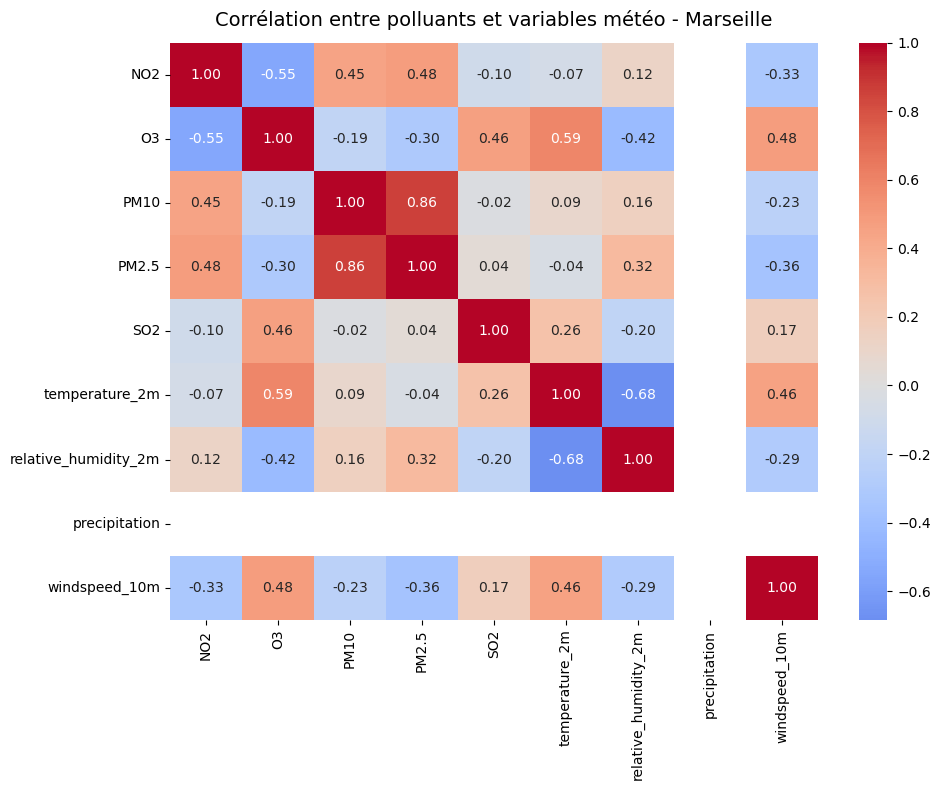

In [23]:
# --- 6. Heatmap des corrélations ---
plt.figure(figsize=(10, 8))
corr_matrix = df_merged.corr(numeric_only=True)  # corrélation uniquement sur les colonnes numériques
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Corrélation entre polluants et variables météo - Marseille", fontsize=14, pad=12)
plt.tight_layout()
plt.show()


In [11]:
query = """
SELECT s.nom_station, s.latitude, s.longitude, m.polluant, m.valeur, m.qualificatif
FROM public.mesure_journaliere m
JOIN public.station s ON m.id_station = s.id_station
;
"""

df = pd.read_sql(query, engine)
print(df.head())


                    nom_station   latitude  longitude polluant  valeur  \
0  Nice - Station Aéroport Nice  43.657745   7.201944      SO2     1.0   
1  Nice - Station Aéroport Nice  43.657745   7.201944      NO2     7.3   
2  Nice - Station Aéroport Nice  43.657745   7.201944       O3    75.9   
3  Nice - Station Aéroport Nice  43.657745   7.201944     PM10    19.1   
4  Nice - Station Aéroport Nice  43.657745   7.201944    PM2.5    12.8   

  qualificatif  
0          Bon  
1          Bon  
2        Moyen  
3          Bon  
4        Moyen  


In [20]:
import folium
import pandas as pd
from sqlalchemy import create_engine

# --- Connexion à la base ---
PGHOST = "localhost"
PGPORT = "5432"
PGDB   = "qualair_db"
PGUSER = "yasminedri"
PGPASS = "qualair"
DB_URL = f"postgresql+psycopg2://{PGUSER}:{PGPASS}@{PGHOST}:{PGPORT}/{PGDB}"
engine = create_engine(DB_URL)

# --- Récupération des données du jour ---
query = """
SELECT s.nom_station, s.latitude, s.longitude, m.polluant, m.valeur, m.qualificatif
FROM public.mesure_journaliere m
JOIN public.station s ON m.id_station = s.id_station
WHERE m.date::date = CURRENT_DATE
"""
df = pd.read_sql(query, engine)

# --- Nouvelle palette de couleurs ---
couleurs_atmo = {
    "Bon": "#B2FBA5",
    "Moyen": "#FFF44F",
    "Dégradé": "#F9AB59",
    "Mauvais": "#FF6961",
    "Très mauvais": "#C3B1E1",
    "Extrêmement mauvais": "black"
}

# --- Carte avec fond clair et zoom PACA ---
m = folium.Map(location=[43.8, 5.5], zoom_start=8, tiles="CartoDB positron")

# --- Ajout des cercles proportionnels ---
for _, row in df.iterrows():
    couleur = couleurs_atmo.get(row["qualificatif"], "gray")
    taille = max(6, min(row["valeur"] / 2, 20))  # Taille proportionnelle à la valeur
    popup_text = f"""
    <b>Station :</b> {row['nom_station']}<br>
    <b>Polluant :</b> {row['polluant']}<br>
    <b>Valeur :</b> {row['valeur']} µg/m³<br>
    <b>Qualité :</b> {row['qualificatif']}
    """
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=taille,
        color=couleur,
        fill=True,
        fill_color=couleur,
        fill_opacity=0.85,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# --- Légende ---
legend_html = """
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 170px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px; border-radius:5px;">
<b>Indice ATMO</b><br>
<i style="background:#B2FBA5; width:10px; height:10px; float:left; margin-right:5px;"></i> Bon<br>
<i style="background:#FFF44F; width:10px; height:10px; float:left; margin-right:5px;"></i> Moyen<br>
<i style="background:#F9AB59; width:10px; height:10px; float:left; margin-right:5px;"></i> Dégradé<br>
<i style="background:#FF6961; width:10px; height:10px; float:left; margin-right:5px;"></i> Mauvais<br>
<i style="background:#C3B1E1; width:10px; height:10px; float:left; margin-right:5px;"></i> Très mauvais<br>
<i style="background:black; width:10px; height:10px; float:left; margin-right:5px;"></i> Extrêmement mauvais
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- Sauvegarde ---
m.save("carte_paca.html")
m


In [14]:
import pandas as pd
import plotly.graph_objects as go
from sqlalchemy import create_engine

# --- Connexion PostgreSQL ---
PGHOST = "localhost"
PGPORT = "5432"
PGDB   = "qualair_db"
PGUSER = "yasminedri"
PGPASS = "qualair"
DB_URL = f"postgresql+psycopg2://{PGUSER}:{PGPASS}@{PGHOST}:{PGPORT}/{PGDB}"
engine = create_engine(DB_URL)

# --- Ville à filtrer ---
ville = "Marseille"

# --- Lecture trafic ---
df_trafic = pd.read_sql(f"""
SELECT date, heure, trafic, ville
FROM public.trafic_synthetique
WHERE ville = '{ville}'
""", engine)
df_trafic['date_heure'] = pd.to_datetime(df_trafic['date'].astype(str) + ' ' + df_trafic['heure'].astype(str))

# --- Lecture mesures NO2 ---
df_mesures = pd.read_sql(f"""
SELECT m.date, m.heure, m.polluant, m.valeur, s.ville
FROM public.mesure_journaliere m
JOIN public.station s ON m.id_station = s.id_station
WHERE m.polluant = 'NO2' AND s.ville = '{ville}'
""", engine)
df_mesures['date_heure'] = pd.to_datetime(df_mesures['date'].astype(str) + ' ' + df_mesures['heure'].astype(str))

# --- Agrégation par heure ---
trafic_hourly = df_trafic.groupby(df_trafic['date_heure'].dt.hour)['trafic'].mean()
no2_hourly = df_mesures.groupby(df_mesures['date_heure'].dt.hour)['valeur'].mean()

# --- Graphique double axe ---
fig = go.Figure()

# NO2
fig.add_trace(go.Scatter(
    x=no2_hourly.index, y=no2_hourly.values,
    mode='lines+markers',
    name='NO₂ (µg/m³)',
    yaxis='y1',
    line=dict(color='red', width=3),
    marker=dict(size=8)
))

# Trafic
fig.add_trace(go.Scatter(
    x=trafic_hourly.index, y=trafic_hourly.values,
    mode='lines+markers',
    name='Trafic (%)',
    yaxis='y2',
    line=dict(color='blue', width=3),
    marker=dict(size=8)
))

# Ligne de seuil NO₂ (OMS : 40 µg/m³)
fig.add_hline(
    y=40,
    line_dash="dash",
    line_color="orange",
    annotation_text="Seuil OMS (40 µg/m³)",
    annotation_position="top left",
    annotation_font_color="orange"
)

# Mise en forme
fig.update_layout(
    title=f"No2 et trafic en fonctions des heures({ville})",
    xaxis=dict(
        title="Heure de la journée",
        tickmode='array',
        tickvals=list(range(0, 24)),
        ticktext=[f"{h}h" for h in range(0, 24)]
    ),
    yaxis=dict(title="NO₂ (µg/m³)", color='red', range=[0, max(no2_hourly.max(), 45) + 5]),
    yaxis2=dict(title="Trafic (%)", overlaying='y', side='right', color='blue'),
    template="plotly_white"
)

fig.show()


Corrélation Pearson NO₂ / Trafic (Marseille) : 0.14


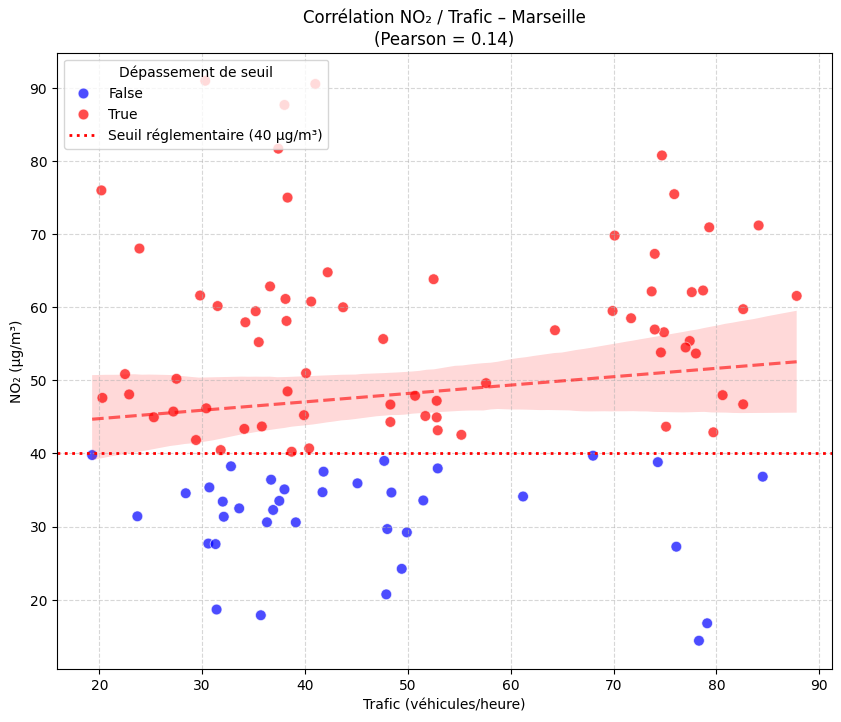

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ... (les étapes 1 à 4 de votre code, inchangées) ...

# --- 5. Ajout de la colonne de seuil ---
SEUIL_NO2 = 40
df_no2_trafic['alerte'] = df_no2_trafic['no2'] > SEUIL_NO2

# --- 6. Corrélation Pearson (inchangé) ---
corr_value = df_no2_trafic['no2'].corr(df_no2_trafic['trafic'])
print(f"Corrélation Pearson NO₂ / Trafic ({ville_cible}) : {corr_value:.2f}")

# --- 7. Scatter + régression avec coloration par seuil ---
plt.figure(figsize=(10, 8))
# On utilise hue pour colorer les points en fonction de la colonne 'alerte'
sns.scatterplot(
    data=df_no2_trafic,
    x="trafic",
    y="no2",
    hue="alerte",  # La variable 'alerte' détermine la couleur
    palette={True: 'red', False: 'blue'}, # True (alerte) en rouge, False en bleu
    s=60, # Taille des points
    alpha=0.7
)

# Ajout de la ligne de régression manuellement si nécessaire
sns.regplot(
    data=df_no2_trafic,
    x="trafic",
    y="no2",
    scatter=False,
    line_kws={"color":"red", "linestyle":"--", "alpha":0.6}
)

# Ajout de la ligne de seuil horizontale
plt.axhline(y=SEUIL_NO2, color='red', linestyle=':', linewidth=2, label=f'Seuil réglementaire ({SEUIL_NO2} µg/m³)')


plt.title(f"Corrélation NO₂ / Trafic – {ville_cible}\n(Pearson = {corr_value:.2f})")
plt.xlabel("Trafic (véhicules/heure)")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title='Dépassement de seuil', loc='upper left')
plt.show()

# --- 8. Heatmap corrélations (le reste de votre code, inchangé) ---
# ... (votre code pour la heatmap) ...

Corrélation Pearson NO₂ / Trafic : nan


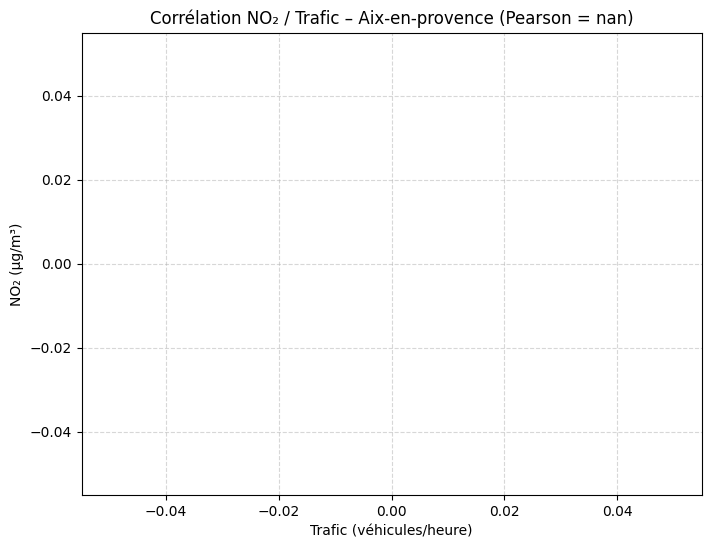

ValueError: You are trying to merge on object and datetime64[ns] columns for key 'heure'. If you wish to proceed you should use pd.concat

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paramètres ---
ville_cible = "Nimes"
periode_debut = "2025-08-08"
periode_fin = "2025-08-15"

# --- 1. NO2 (moyenne horaire) ---
query_no2 = f"""
SELECT DATE_TRUNC('hour', m.datetime) AS heure,
       AVG(m.valeur) AS no2
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = '{ville_cible}'
  AND m.polluant = 'NO2'
  AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
  AND m.valeur IS NOT NULL
GROUP BY 1
ORDER BY 1;
"""
df_no2 = pd.read_sql(query_no2, engine)

# --- 2. Trafic (moyenne horaire) ---
query_trafic = f"""
SELECT (date + heure) AS heure,
       AVG(trafic) AS trafic
FROM trafic_synthetique
WHERE ville = '{ville_cible}'
  AND date BETWEEN '{periode_debut}' AND '{periode_fin}'
GROUP BY 1
ORDER BY 1;
"""
df_trafic = pd.read_sql(query_trafic, engine)

# --- Harmoniser les formats datetime ---
df_no2["heure"] = pd.to_datetime(df_no2["heure"]).dt.tz_localize(None)
df_trafic["heure"] = pd.to_datetime(df_trafic["heure"]).dt.tz_localize(None)

# --- 3. Fusion ---
df_merged = pd.merge(df_no2, df_trafic, on="heure", how="inner")

# --- 4. Pearson ---
corr_value = df_merged["no2"].corr(df_merged["trafic"])
print(f"Corrélation Pearson NO₂ / Trafic : {corr_value:.2f}")

# --- 5. Scatter avec régression ---
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_merged,
    x="trafic", y="no2",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.title(f"Corrélation NO₂ / Trafic – {ville_cible} (Pearson = {corr_value:.2f})")
plt.xlabel("Trafic (véhicules/heure)")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --- 6. Matrice de corrélation élargie (polluants + trafic) ---
query_polluants = f"""
SELECT DATE_TRUNC('hour', m.datetime) AS heure,
       m.polluant, m.valeur
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = '{ville_cible}'
  AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
  AND m.valeur IS NOT NULL;
"""
df_polluants = pd.read_sql(query_polluants, engine)

# Pivot → colonnes = polluants
df_polluants_pivot = (
    df_polluants
    .groupby(["heure", "polluant"])["valeur"].mean()
    .unstack()
    .reset_index()
)

# Ajout du trafic
df_all = pd.merge(df_polluants_pivot, df_trafic, on="heure", how="inner")

# Matrice des corrélations (Pearson par défaut)
plt.figure(figsize=(10,8))
corr_matrix = df_all.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title(f"Matrice de corrélation (polluants + trafic) – {ville_cible}")
plt.tight_layout()
plt.show()


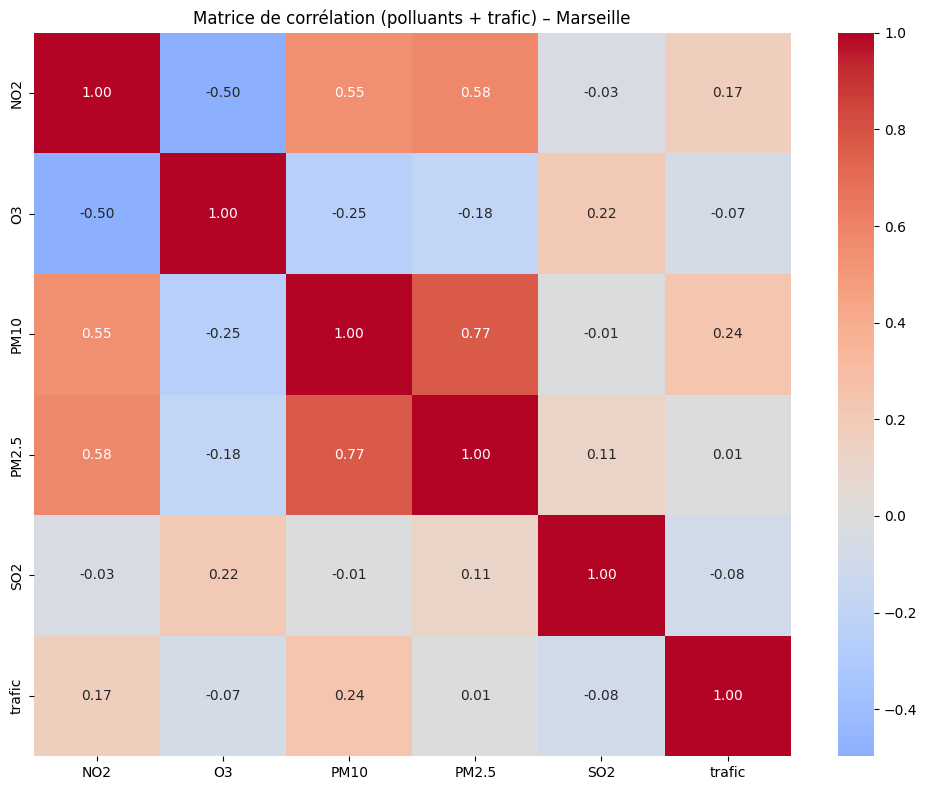

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Harmoniser les formats datetime AVANT merge ---
df_no2["heure"] = pd.to_datetime(df_no2["heure"]).dt.tz_localize(None)
df_trafic["heure"] = pd.to_datetime(df_trafic["heure"]).dt.tz_localize(None)

df_polluants["heure"] = pd.to_datetime(df_polluants["heure"]).dt.tz_localize(None)

df_polluants_pivot = (
    df_polluants
    .groupby(["heure", "polluant"])["valeur"].mean()
    .unstack()
    .reset_index()
)

# Harmonisation encore une fois (sécurité)
df_polluants_pivot["heure"] = pd.to_datetime(df_polluants_pivot["heure"]).dt.tz_localize(None)

# --- Fusion avec le trafic ---
df_all = pd.merge(df_polluants_pivot, df_trafic, on="heure", how="inner")

# --- Matrice des corrélations ---
plt.figure(figsize=(10,8))
corr_matrix = df_all.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title(f"Matrice de corrélation (polluants + trafic) – {ville_cible}")
plt.tight_layout()
plt.show()


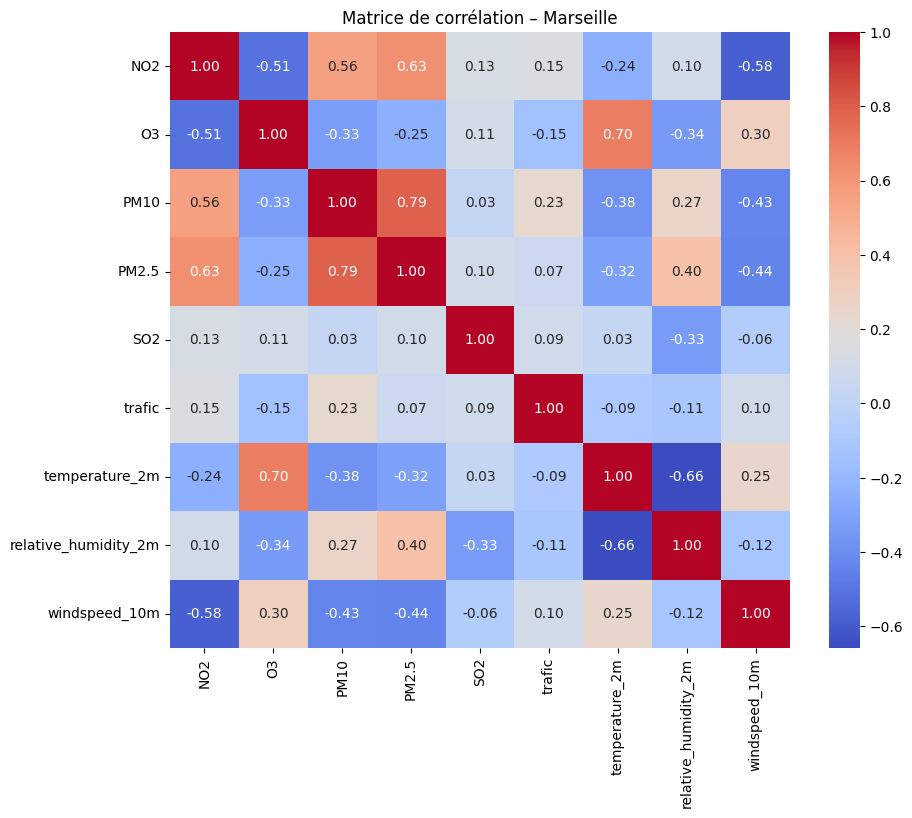

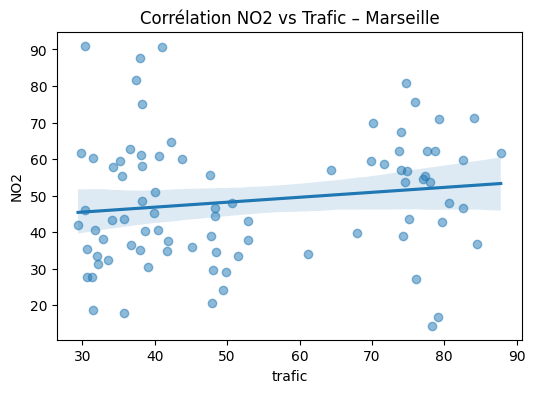

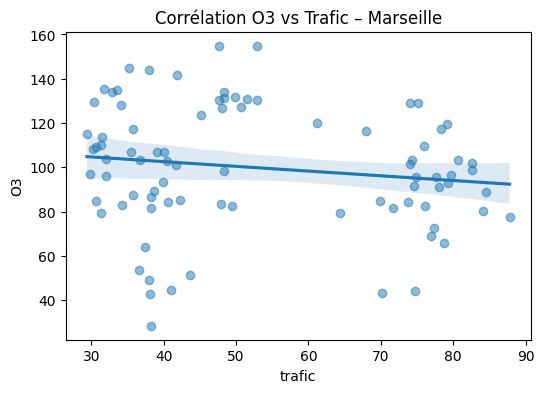

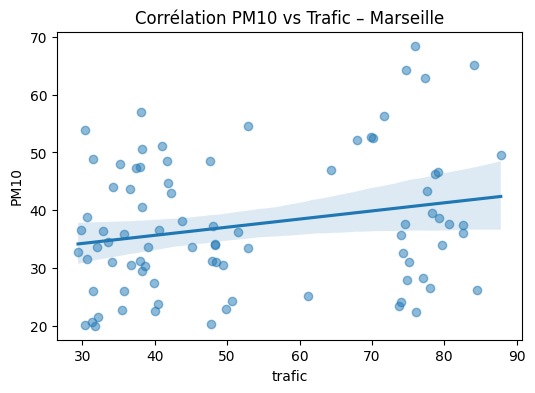

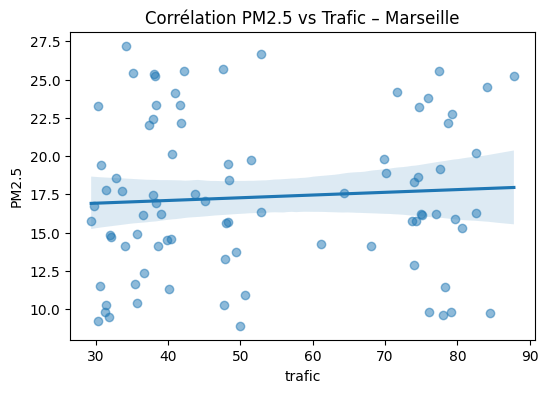

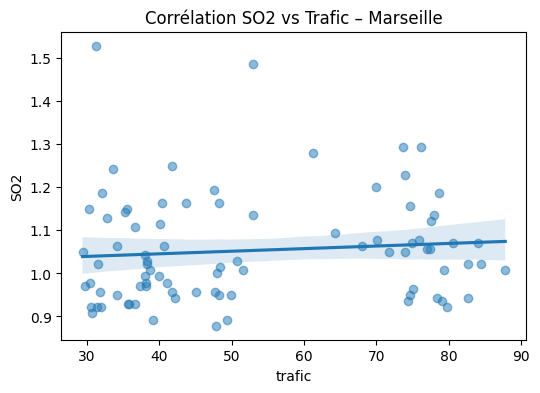

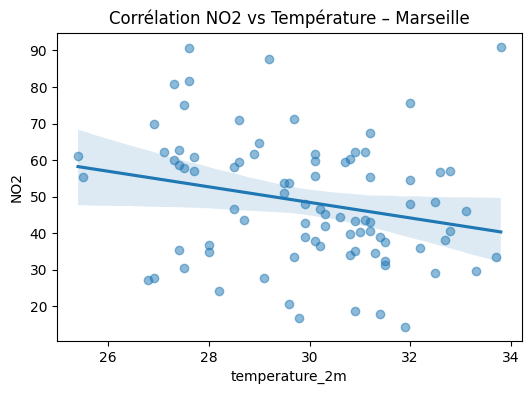

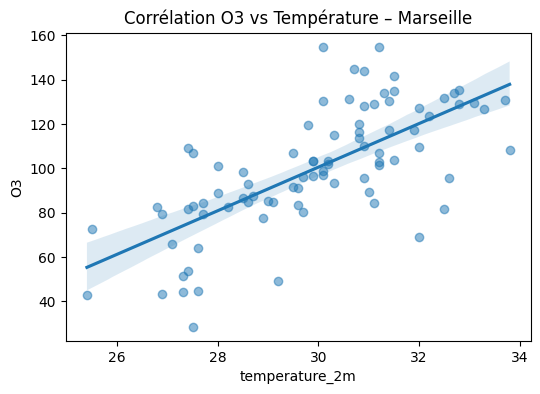

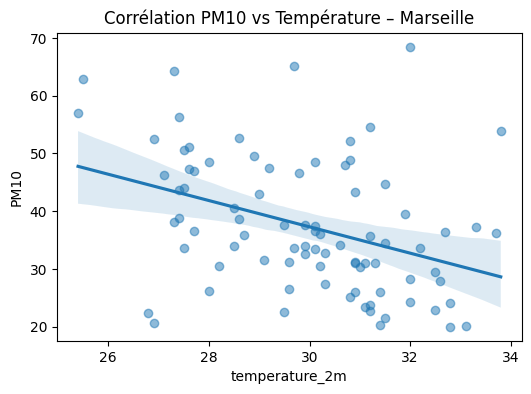

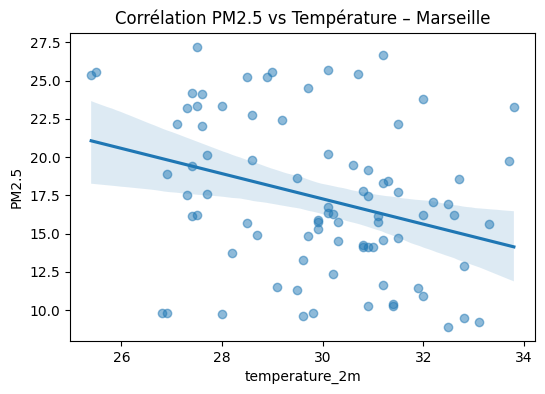

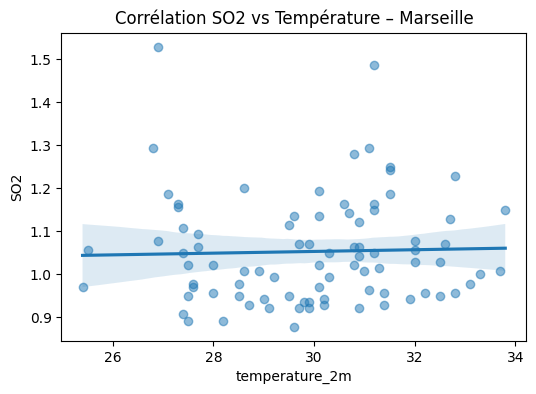

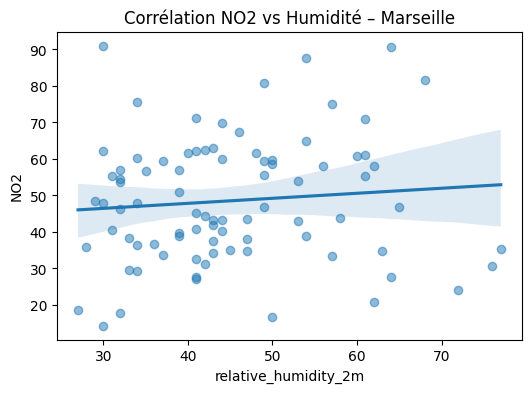

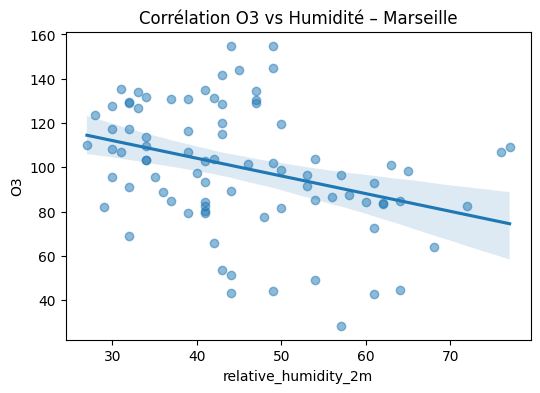

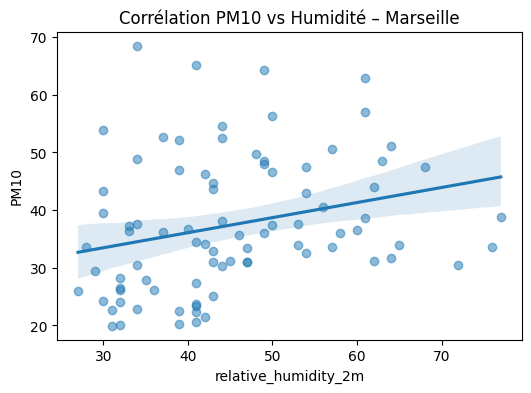

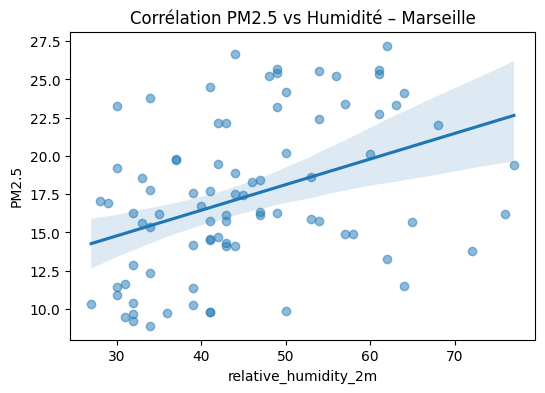

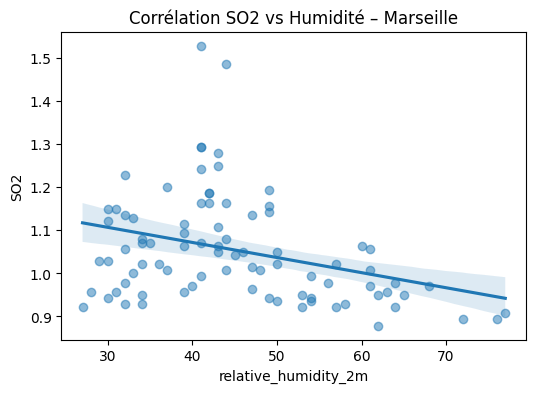

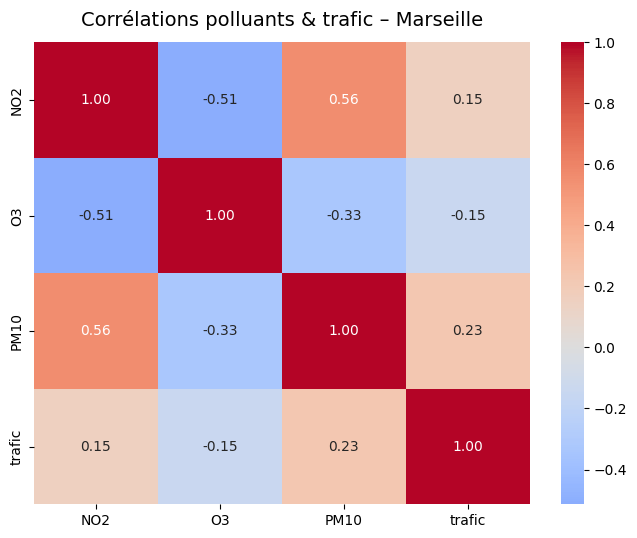

NO2 > 40.0 µg/m³ : 55/85 heures (64.7 %)

Corrélations Pearson (NO2 vs variables) :
  NO2 ~ trafic               : r =  0.15
  NO2 ~ temperature_2m       : r = -0.24
  NO2 ~ relative_humidity_2m : r =  0.10
  NO2 ~ windspeed_10m        : r = -0.58

=== OLS (NO2 ~ trafic + météo) ===
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     12.65
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           5.04e-08
Time:                        11:25:12   Log-Likelihood:                -340.86
No. Observations:                  85   AIC:                             691.7
Df Residuals:                      80   BIC:                             703.9
Df Model:                           4                                         
Covar

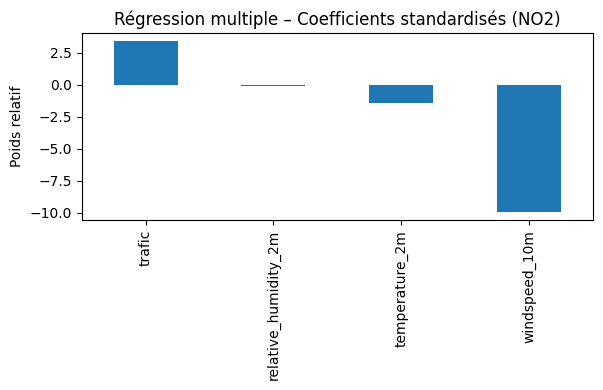

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

# ----------------------
# Connexion DB
# ----------------------
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "qualair_db")
DB_USER = os.getenv("DB_USER", "yasminedri")
DB_PASS = os.getenv("DB_PASS", "qualair")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# ----------------------
# Paramètres
# ----------------------
ville_cible = "Marseille"
periode_debut = "2025-08-08"
periode_fin = "2025-08-15"

# ----------------------
# 1. Charger Polluants
# ----------------------
query_polluants = f"""
SELECT m.datetime, m.polluant, m.valeur
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = '{ville_cible}'
  AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
"""
df_polluants = pd.read_sql(query_polluants, engine)
df_polluants["heure"] = pd.to_datetime(df_polluants["datetime"]).dt.floor("h").dt.tz_localize(None)

# Pivot pour avoir 1 colonne par polluant
df_polluants_pivot = (
    df_polluants.groupby(["heure", "polluant"])["valeur"].mean()
    .unstack()
    .reset_index()
)

# ----------------------
# 2. Charger Trafic
# ----------------------
query_trafic = f"""
SELECT date, heure, ville, trafic
FROM trafic_synthetique
WHERE ville = '{ville_cible}'
  AND date BETWEEN '{periode_debut}' AND '{periode_fin}'
"""
df_trafic = pd.read_sql(query_trafic, engine)

# Fusionner date + heure
df_trafic["heure"] = pd.to_datetime(df_trafic["date"].astype(str) + " " + df_trafic["heure"].astype(str))
df_trafic["heure"] = df_trafic["heure"].dt.floor("h").dt.tz_localize(None)

# ----------------------
# 3. Charger Météo
# ----------------------
query_meteo = f"""
SELECT time, temperature_2m, relative_humidity_2m, windspeed_10m
FROM meteo
WHERE ville = '{ville_cible}'
  AND time BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
"""
df_meteo = pd.read_sql(query_meteo, engine)
df_meteo["heure"] = pd.to_datetime(df_meteo["time"]).dt.floor("h").dt.tz_localize(None)

# ----------------------
# 4. Fusion des datasets
# ----------------------
df_all = df_polluants_pivot.merge(df_trafic[["heure", "trafic"]], on="heure", how="inner")
df_all = df_all.merge(df_meteo[["heure", "temperature_2m", "relative_humidity_2m", "windspeed_10m"]],
                      on="heure", how="inner")

# ----------------------
# 5. Corrélations
# ----------------------
corr = df_all.drop(columns=["heure"]).corr(method="pearson")

# ----------------------
# 6. Graphiques
# ----------------------

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Matrice de corrélation – {ville_cible}")
plt.show()

# Scatter plots avec droite de régression
# Scatter plot Polluants vs Trafic
for col in df_polluants_pivot.columns:
    if col not in ["heure"]:
        plt.figure(figsize=(6, 4))
        sns.regplot(data=df_all, x="trafic", y=col, scatter_kws={'alpha':0.5})
        plt.title(f"Corrélation {col} vs Trafic – {ville_cible}")
        plt.show()

# Scatter plot Polluants vs Température
for col in df_polluants_pivot.columns:
    if col not in ["heure"]:
        plt.figure(figsize=(6, 4))
        sns.regplot(data=df_all, x="temperature_2m", y=col, scatter_kws={'alpha':0.5})
        plt.title(f"Corrélation {col} vs Température – {ville_cible}")
        plt.show()

# Scatter plot Polluants vs Humidité
for col in df_polluants_pivot.columns:
    if col not in ["heure"]:
        plt.figure(figsize=(6, 4))
        sns.regplot(data=df_all, x="relative_humidity_2m", y=col, scatter_kws={'alpha':0.5})
        plt.title(f"Corrélation {col} vs Humidité – {ville_cible}")
        plt.show()

# Matrice de corrélation complète
# (ce script est déjà dans votre code, pas besoin de le modifier)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

query_polluants = f"""
SELECT DATE_TRUNC('hour', m.datetime) AS heure,
       m.polluant,
       AVG(m.valeur) AS valeur
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = '{ville_cible}'
  AND m.polluant IN ('NO2','PM10','O3')
  AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
  AND m.valeur IS NOT NULL
GROUP BY 1, m.polluant
ORDER BY 1
"""
df_polluants = pd.read_sql(query_polluants, engine)
df_polluants_pivot = df_polluants.pivot(index="heure", columns="polluant", values="valeur").reset_index()

query_trafic = f"""
SELECT DATE_TRUNC('hour', (date::timestamp + heure)) AS heure,
       AVG(trafic) AS trafic
FROM trafic_synthetique
WHERE ville = '{ville_cible}'
  AND date BETWEEN '{periode_debut}' AND '{periode_fin}'
GROUP BY 1
ORDER BY 1
"""
df_trafic = pd.read_sql(query_trafic, engine)

df_polluants_pivot["heure"] = pd.to_datetime(df_polluants_pivot["heure"]).dt.tz_localize(None)
df_trafic["heure"] = pd.to_datetime(df_trafic["heure"]).dt.tz_localize(None)

df_merge = pd.merge(df_polluants_pivot, df_trafic, on="heure", how="inner")

corr_matrix = df_merge.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title(f"Corrélations polluants & trafic – {ville_cible}", fontsize=14, pad=12)
plt.show()
# =========================
#  A) Préparation des données
# =========================
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# On garde les colonnes utiles et on supprime les lignes incomplètes
cols = ["NO2", "trafic", "temperature_2m", "relative_humidity_2m", "windspeed_10m"]
dfm = df_all[["heure"] + [c for c in cols if c in df_all.columns]].dropna()

# =========================
#  B) Dépassements réglementaires NO2
# =========================
SEUIL_NO2 = 40.0
nb_total = len(dfm)
nb_dep = int((dfm["NO2"] > SEUIL_NO2).sum())
taux_dep = (nb_dep / nb_total * 100) if nb_total else 0.0
print(f"NO2 > {SEUIL_NO2} µg/m³ : {nb_dep}/{nb_total} heures ({taux_dep:.1f} %)")

# =========================
#  C) Corrélations rapides (rappel synthétique)
# =========================
print("\nCorrélations Pearson (NO2 vs variables) :")
for var in ["trafic", "temperature_2m", "relative_humidity_2m", "windspeed_10m"]:
    if var in dfm.columns:
        r = dfm["NO2"].corr(dfm[var])
        print(f"  NO2 ~ {var:20s} : r = {r: .2f}")

# =========================
#  D) Régression multiple (OLS)
# =========================
y = dfm["NO2"]
X = dfm[[c for c in ["trafic", "temperature_2m", "relative_humidity_2m", "windspeed_10m"] if c in dfm.columns]]

# Optionnel : standardiser pour comparer l'importance relative des coefficients
X_std = (X - X.mean()) / X.std(ddof=0)

X_std = sm.add_constant(X_std)  # constante
model = sm.OLS(y, X_std, missing="drop").fit()

print("\n=== OLS (NO2 ~ trafic + météo) ===")
print(model.summary())

# =========================
#  E) Test d’hétéroscédasticité (Breusch–Pagan)
# =========================
bp_lm, bp_lmpval, fval, fpval = het_breuschpagan(model.resid, model.model.exog)
print("\nBreusch–Pagan test")
print(f"  LM stat = {bp_lm:.2f}, p-value = {bp_lmpval:.4f}  |  F stat = {fval:.2f}, p-value = {fpval:.4f}")

# Interprétation rapide
if bp_lmpval < 0.05:
    print("→ Hétéroscédasticité détectée (p < 0,05) : prudence sur les intervalles de confiance.")
else:
    print("→ Pas d’évidence forte d’hétéroscédasticité (p ≥ 0,05).")

# =========================
#  F) Importance relative des variables (coefficients standardisés)
# =========================
coef = model.params.drop("const").sort_values(ascending=False)
print("\nCoefficients standardisés (ordre décroissant) :")
print(coef)

# =========================
#  G) Graphique optionnel : barre des coefficients
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
coef.plot(kind="bar")
plt.title("Régression multiple – Coefficients standardisés (NO2)")
plt.ylabel("Poids relatif")
plt.tight_layout()
plt.show()


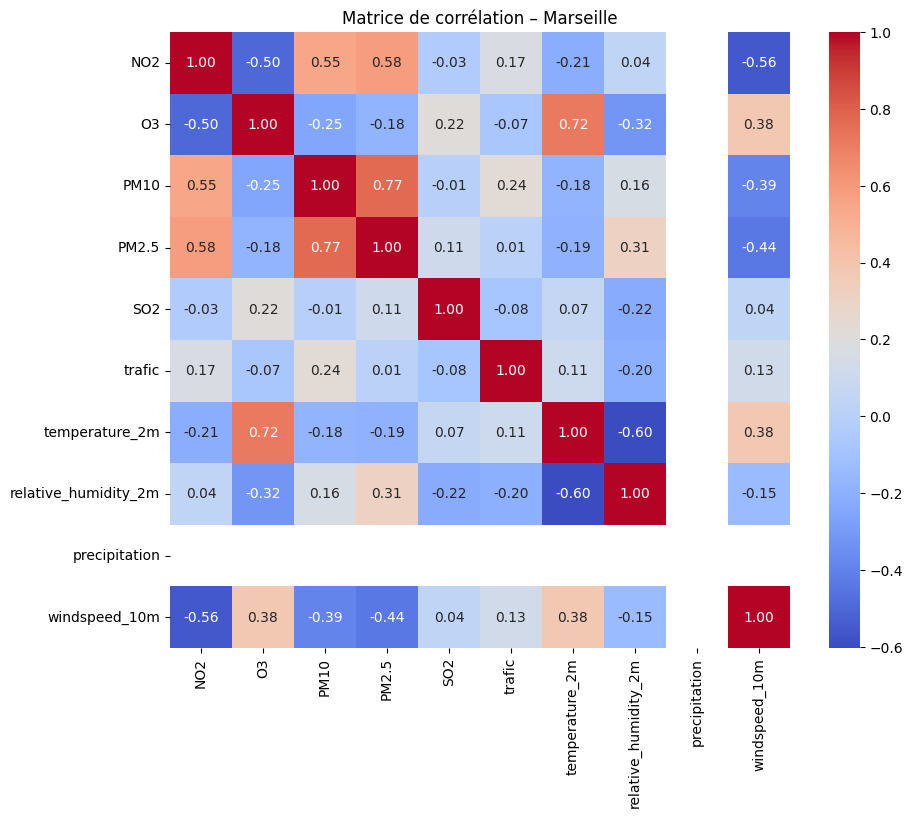

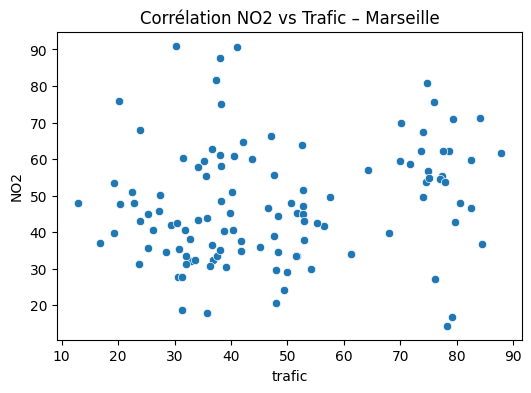

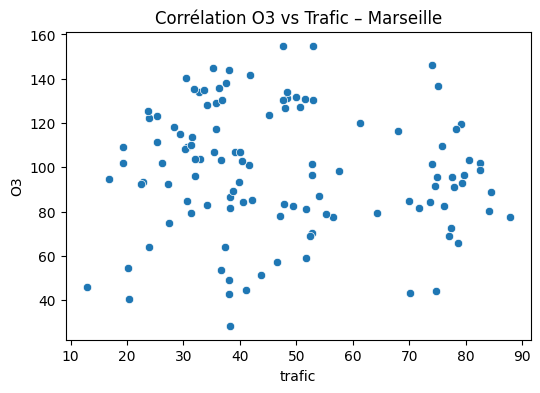

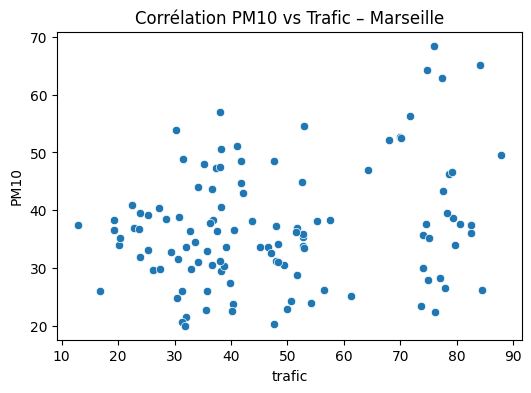

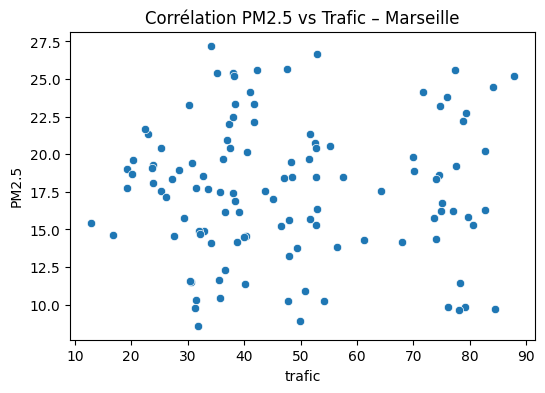

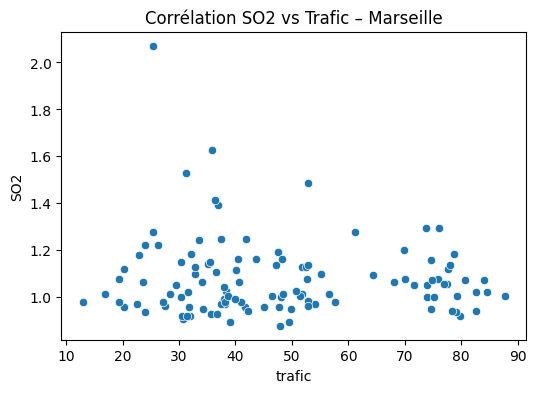

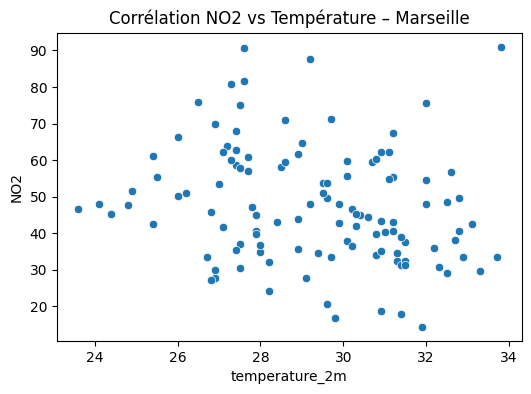

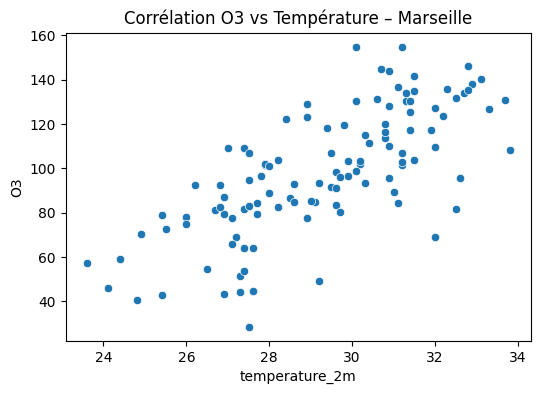

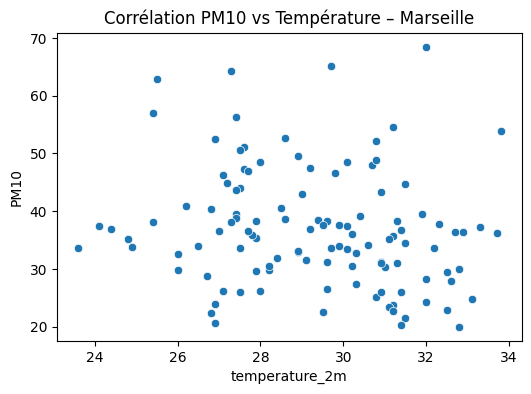

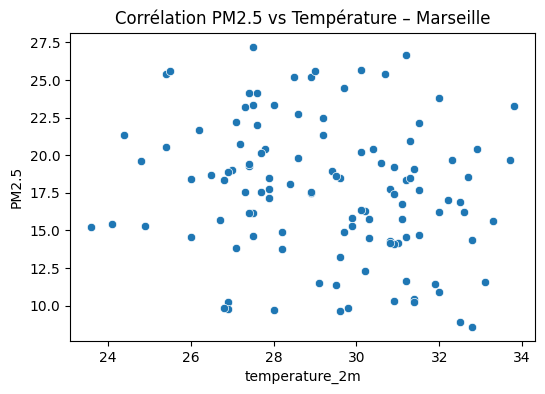

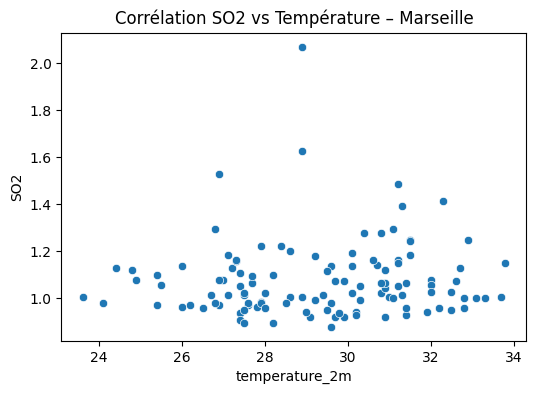

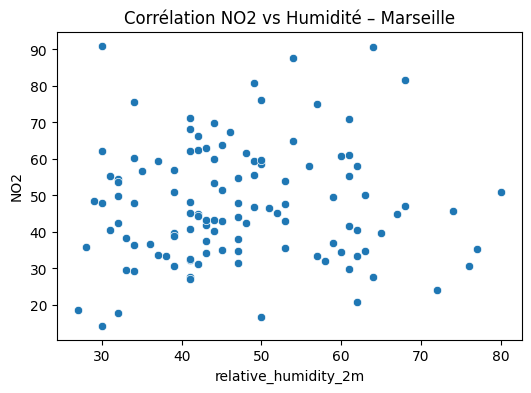

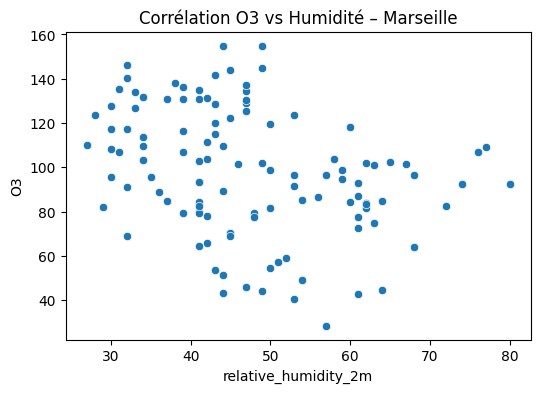

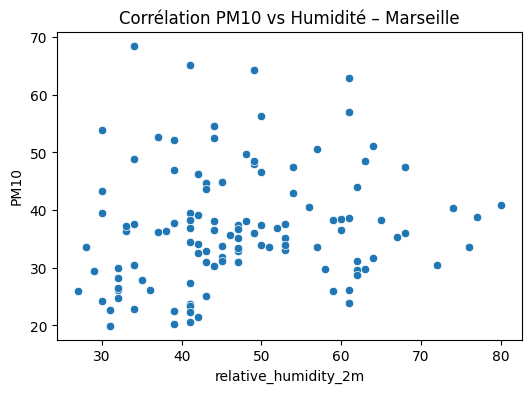

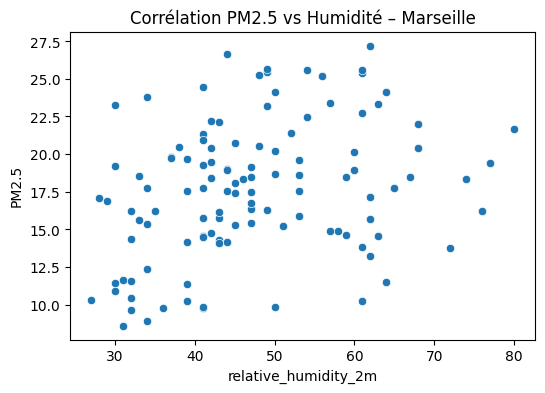

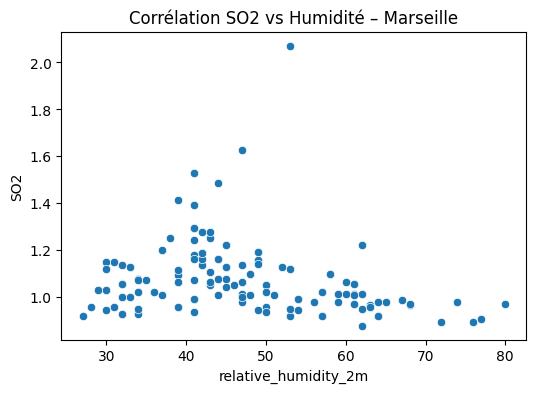

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

# ----------------------
# Connexion DB
# ----------------------
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "qualair_db")
DB_USER = os.getenv("DB_USER", "yasminedri")
DB_PASS = os.getenv("DB_PASS", "qualair")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# ----------------------
# Paramètres
# ----------------------
ville_cible = "Marseille"
periode_debut = "2025-08-08"
periode_fin = "2025-08-15"

# ----------------------
# 1. Charger Polluants
# ----------------------
query_polluants = f"""
SELECT m.datetime, m.polluant, m.valeur
FROM mesure_journaliere m
JOIN station s ON m.id_station = s.id_station
WHERE s.ville = '{ville_cible}'
  AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
"""
df_polluants = pd.read_sql(query_polluants, engine)
df_polluants["heure"] = pd.to_datetime(df_polluants["datetime"]).dt.floor("h").dt.tz_localize(None)

# Pivot pour avoir 1 colonne par polluant
df_polluants_pivot = (
    df_polluants.groupby(["heure", "polluant"])["valeur"].mean()
    .unstack()
    .reset_index()
)

# ----------------------
# 2. Charger Trafic
# ----------------------
query_trafic = f"""
SELECT date, heure, ville, trafic
FROM trafic_synthetique
WHERE ville = '{ville_cible}'
  AND date BETWEEN '{periode_debut}' AND '{periode_fin}'
"""
df_trafic = pd.read_sql(query_trafic, engine)

# Fusionner date + heure
df_trafic["heure"] = pd.to_datetime(df_trafic["date"].astype(str) + " " + df_trafic["heure"].astype(str))
df_trafic["heure"] = df_trafic["heure"].dt.floor("h").dt.tz_localize(None)

# ----------------------
# 3. Charger Météo
# ----------------------
query_meteo = f"""
SELECT time, temperature_2m, relative_humidity_2m, windspeed_10m
FROM meteo
WHERE ville = '{ville_cible}'
  AND time BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
"""
df_meteo = pd.read_sql(query_meteo, engine)
df_meteo["heure"] = pd.to_datetime(df_meteo["time"]).dt.floor("h").dt.tz_localize(None)

# ----------------------
# 4. Fusion des datasets
# ----------------------
df_all = df_polluants_pivot.merge(df_trafic[["heure", "trafic"]], on="heure", how="inner")
df_all = df_all.merge(df_meteo[["heure", "temperature_2m", "relative_humidity_2m", "windspeed_10m"]],
                      on="heure", how="inner")

# ----------------------
# 5. Corrélations
# ----------------------
corr = df_all.drop(columns=["heure"]).corr(method="pearson")

# ----------------------
# 6. Graphiques
# ----------------------
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Matrice de corrélation – {ville_cible}")
plt.show()

# Scatter plot Polluants vs Trafic
for col in df_polluants_pivot.columns:
    if col not in ["heure"]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df_all, x="trafic", y=col)
        plt.title(f"Corrélation {col} vs Trafic – {ville_cible}")
        plt.show()

# Scatter plot Polluants vs Température
for col in df_polluants_pivot.columns:
    if col not in ["heure"]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df_all, x="temperature_2m", y=col)
        plt.title(f"Corrélation {col} vs Température – {ville_cible}")
        plt.show()

# Scatter plot Polluants vs Humidité
for col in df_polluants_pivot.columns:
    if col not in ["heure"]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df_all, x="relative_humidity_2m", y=col)
        plt.title(f"Corrélation {col} vs Humidité – {ville_cible}")
        plt.show()


In [49]:
import pandas as pd
from sqlalchemy import text

ville_cible = "Marseille"
periode_debut = "2025-08-09"
periode_fin = "2025-08-15"

query = f"""
WITH polluants AS (
    SELECT DATE_TRUNC('hour', m.datetime) AS heure,
           m.polluant,
           AVG(m.valeur) AS moyenne_polluant
    FROM mesure_journaliere m
    JOIN station s ON m.id_station = s.id_station
    WHERE s.ville = '{ville_cible}'
      AND m.datetime BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
      AND m.valeur IS NOT NULL
    GROUP BY DATE_TRUNC('hour', m.datetime), m.polluant
),
trafic AS (
    SELECT (t.date + t.heure)::timestamp AS heure,
           AVG(t.trafic) AS trafic
    FROM trafic_synthetique t
    WHERE t.ville = '{ville_cible}'
      AND t.date BETWEEN '{periode_debut}' AND '{periode_fin}'
    GROUP BY (t.date + t.heure)
),
meteo AS (
    SELECT DATE_TRUNC('hour', me.time) AS heure,
           AVG(me.temperature_2m) AS temperature_2m,
           AVG(me.relative_humidity_2m) AS relative_humidity_2m,
           AVG(me.windspeed_10m) AS windspeed_10m
    FROM meteo me
    WHERE me.ville = '{ville_cible}'
      AND me.time BETWEEN '{periode_debut}' AND '{periode_fin}'::date + interval '1 day'
    GROUP BY DATE_TRUNC('hour', me.time)
)
SELECT p.heure,
       MAX(CASE WHEN p.polluant = 'NO2' THEN p.moyenne_polluant END) AS NO2,
       MAX(CASE WHEN p.polluant = 'PM10' THEN p.moyenne_polluant END) AS PM10,
       MAX(CASE WHEN p.polluant = 'O3' THEN p.moyenne_polluant END) AS O3,
       t.trafic,
       me.temperature_2m,
       me.relative_humidity_2m,
       me.windspeed_10m
FROM polluants p
JOIN trafic t ON p.heure = t.heure
JOIN meteo me ON p.heure = me.heure
GROUP BY p.heure, t.trafic, me.temperature_2m, me.relative_humidity_2m, me.windspeed_10m
ORDER BY p.heure;
"""

df_corr = pd.read_sql(text(query), engine)
df_corr


,heure,no2,pm10,o3,trafic,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m
0,2025-08-09 06:00:00+00:00,48.014286,37.483333,46.10,12.9,24.1,47.0,0.0,7.6
1,2025-08-09 07:00:00+00:00,46.500000,33.633333,57.28,46.5,23.6,51.0,0.0,5.4
2,2025-08-09 08:00:00+00:00,51.528571,33.816667,70.22,52.7,24.9,45.0,0.0,1.9
3,2025-08-09 09:00:00+00:00,66.257143,32.583333,77.96,47.1,26.0,42.0,0.0,3.8
4,2025-08-09 10:00:00+00:00,53.314286,36.516667,109.42,19.3,27.0,44.0,0.0,5.1
...,...,...,...,...,...,...,...,...,...
110,2025-08-15 14:00:00+00:00,29.200000,22.900000,131.78,49.9,32.5,34.0,0.0,11.1
111,2025-08-15 15:00:00+00:00,40.471429,19.983333,135.42,31.8,32.8,31.0,0.0,10.7
112,2025-08-15 16:00:00+00:00,42.560000,24.720000,140.36,30.4,33.1,32.0,0.0,8.9
113,2025-08-15 17:00:00+00:00,49.720000,30.040000,146.32,74.0,32.8,32.0,0.0,8.7


In [48]:
print("Mesures : ", pd.read_sql(text("SELECT COUNT(*) FROM mesure_journaliere;"), engine))
print("Trafic : ", pd.read_sql(text("SELECT COUNT(*) FROM trafic_synthetique;"), engine))
print("Météo : ", pd.read_sql(text("SELECT COUNT(*) FROM meteo;"), engine))


Mesures :     count
0  67935
Trafic :     count
0  20400
Météo :     count
0   1504
